In [1]:
import numpy as np
import pandas as pd
import tempfile
import json
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.simplefilter('ignore')
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from banditpylib.arms import BernoulliArm
from banditpylib.bandits import OrdinaryBandit
from banditpylib.protocols import SinglePlayerProtocol
from banditpylib.learners.ordinary_learner import UCB, EpsGreedy, ThompsonSampling

In [2]:
horizon = 2000
means = np.array([0.3, 0.5, 0.7])
arms = [BernoulliArm(mean) for mean in means]
bandit = OrdinaryBandit(arms=arms)
learners = [EpsGreedy(arm_num=len(arms), horizon=horizon), 
            UCB(arm_num=len(arms), horizon=horizon),
            ThompsonSampling(arm_num=len(arms), horizon=horizon)]
# for each setup we run 200 trial
trials = 200
gap = 50
# record intermediate regrets for each trial of a game
intermediate_regrets = list(range(0, horizon+1, gap))
temp_file = tempfile.NamedTemporaryFile()

In [3]:
for learner in learners:
  # game simulation
  game = SinglePlayerProtocol(bandit=bandit, learner=learner, intermediate_regrets=intermediate_regrets)
  game.play(trials=trials, output_filename=temp_file.name)

INFO:absl:epsilon_greedy's play with ordinary_bandit runs 3.51 seconds.
INFO:absl:ucb's play with ordinary_bandit runs 5.07 seconds.
INFO:absl:thompson_sampling's play with ordinary_bandit runs 4.45 seconds.


In [4]:
with open(temp_file.name, 'r') as f:
  data = []
  lines = f.readlines()
  for line in lines:
    data.append(json.loads(line))
  data_df = pd.DataFrame.from_dict(data)

In [5]:
data_df.head()

,bandit,learner,rounds,total_actions,regret
0,ordinary_bandit,epsilon_greedy,0,0,0.0
1,ordinary_bandit,epsilon_greedy,50,50,14.0
2,ordinary_bandit,epsilon_greedy,100,100,16.0
3,ordinary_bandit,epsilon_greedy,150,150,23.0
4,ordinary_bandit,epsilon_greedy,200,200,19.0


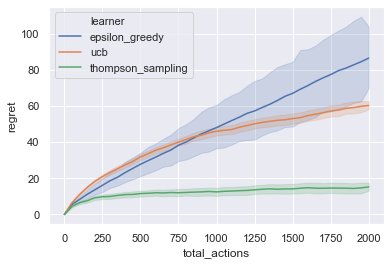

In [6]:
sns.lineplot(x='total_actions', y='regret', hue='learner', data=data_df)